# 과제5

In [77]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
from pandas import Series, DataFrame
import random

#시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import scikitplot as skplt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn.metrics as skl
import sklearn.model_selection as sklm
import sklearn.discriminant_analysis as sk
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import kds

#소수점 3자리까지 표시
%precision 3

'%.3f'

In [2]:
#데이터 불러오기
data = pd.read_csv('loan3000.csv').iloc[:,1:]
data

,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,paid off,debt_consolidation,21.23,0.40,5.11135
1,default,credit_card,15.49,0.40,5.43165
2,paid off,debt_consolidation,27.30,0.70,9.23003
3,paid off,major_purchase,21.11,0.40,2.33482
4,default,debt_consolidation,16.46,0.45,12.10320
...,...,...,...,...,...
2995,paid off,debt_consolidation,13.30,0.50,18.36620
2996,paid off,other,6.09,0.60,1.80421
2997,default,debt_consolidation,16.13,0.20,15.42180
2998,default,debt_consolidation,18.39,0.45,8.92335


## 1) 수치형 독립변수에 대한 공분산 행렬과 상관계수 행렬

### 변수 간 공분산 행렬

In [3]:
# dti와 dti의 공분산
np.cov(data['dti'],data['dti'])

array([[57.622, 57.622],
       [57.622, 57.622]])

In [4]:
# dti의 분산
np.var(data['dti'])
# -> dti와 dti의 공분산값과 같음을 확인할 수 있음

57.602

In [5]:
# borrower_score와 borrower_score의 공분산
np.cov(data['borrower_score'],data['borrower_score'])

array([[0.016, 0.016],
       [0.016, 0.016]])

In [6]:
# borrower_score의 분산
np.var(data['borrower_score'])

0.016

In [7]:
# payment_inc_ratio와 payment_inc_ratio의 공분산
np.cov(data['payment_inc_ratio'],data['payment_inc_ratio'])

array([[18.458, 18.458],
       [18.458, 18.458]])

In [8]:
# payment_inc_ratio의 분산
np.var(data['payment_inc_ratio'])

18.452

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# dti와 borrower_score의 공분산행렬
np.cov(data['dti'],data['borrower_score'])

array([[ 5.762e+01, -2.521e-01],
       [-2.521e-01,  1.646e-02]])

In [10]:
# dti와 payment_inc_ratio의 공분산행렬
np.cov(data['dti'],data['payment_inc_ratio'])

array([[57.622,  7.598],
       [ 7.598, 18.458]])

In [11]:
# borrower_score와 payment_inc_ratio의 공분산행렬
np.cov(data['borrower_score'],data['payment_inc_ratio'])

array([[ 1.646e-02, -6.040e-02],
       [-6.040e-02,  1.846e+01]])

### 변수 간 상관계수 행렬

- 같은 변수끼리의 상관계수는 1이므로 생략

In [12]:
# dti와 borrower_score의 상관계수행렬
np.corrcoef(data['dti'],data['borrower_score'])

array([[ 1.   , -0.259],
       [-0.259,  1.   ]])

In [13]:
# dti와 payment_inc_ratio의 상관계수행렬
np.corrcoef(data['dti'],data['payment_inc_ratio'])

array([[1.   , 0.233],
       [0.233, 1.   ]])

In [14]:
# borrower_score와 payment_inc_ratio의 상관계수행렬
np.corrcoef(data['borrower_score'],data['payment_inc_ratio'])

array([[ 1.  , -0.11],
       [-0.11,  1.  ]])

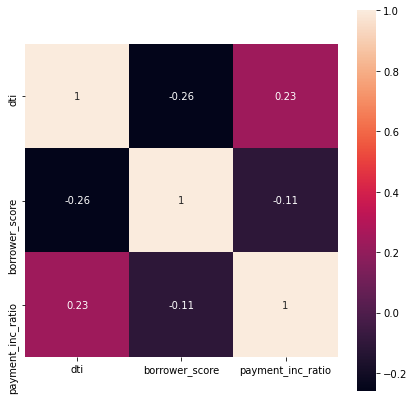

In [15]:
# 상관계수 시각화
plt.figure(figsize=(7,7))
sns.heatmap(data = data.corr(), square = True, annot = True, cbar=True)
plt.show()

## 2) 피셔의 선형판별을 이용한 분류 모델 구축

### x(dit), z(borrower_score)의 가중치 찾기

In [16]:
predictors = ['dti','borrower_score']
outcome = 'outcome'

x = data[predictors]
y = data[outcome]

data_lda = sk.LinearDiscriminantAnalysis()
data_lda.fit(x,y)
pd.DataFrame(data_lda.scalings_, index = x.columns)

,0
dti,-0.036708
borrower_score,7.353988


- x의 가중치: -0.036708, z의 가중치:7.353988

### 혼동행렬 구하기 

In [17]:
pred = data_lda.predict(x)
pred_y = data_lda.predict(x) == 'default'
true_y = y == 'default'
true_pos = true_y&pred_y
true_neg = ~true_y&~pred_y
false_pos = ~true_y&pred_y
false_neg = true_y&~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)],[np.sum(false_pos),np.sum(true_neg)]], index = ['outcome = default(1)','outcome = paid off(0)'], columns = ['pred = default(1)','pred = paid off(0)'])
conf_mat

,pred = default(1),pred = paid off(0)
outcome = default(1),836,609
outcome = paid off(0),540,1015


In [18]:
conf_mat = confusion_matrix(y,data_lda.predict(x))
conf_mat

array([[ 836,  609],
       [ 540, 1015]], dtype=int64)

#### 1) 정확도Accuracy

- (TP+TN)/total 

In [19]:
print('정확도 :',(conf_mat[0,0]+conf_mat[1,1])/len(pred))

정확도 : 0.617


#### 2) 민감도Sensitivty

- TP/(TP+FN) 

In [20]:
print('민감도 :',conf_mat[0,0]/sum(conf_mat[0,:]) )

민감도 : 0.5785467128027681


#### 3) 특이도Specificity

- TN/(TN+FP) 

In [21]:
print('특이도 :', conf_mat[1,1]/sum(conf_mat[1,:]))

특이도 : 0.6527331189710611


#### 4) 정밀도Precision

- TP/(TP+FP) 

In [22]:
print('정밀도 :', conf_mat[0,0]/sum(conf_mat[:,0]))

정밀도 : 0.6075581395348837


## 3) 로지스틱 회귀를 이용한 분류 모델 구축

In [23]:
predictors2 = ['purpose_','dti','borrower_score','payment_inc_ratio']
outcome2 = 'outcome'

X = pd.get_dummies(data[predictors2],prefix = '', prefix_sep = '', drop_first = True)
Y = data[outcome2]

logit_reg = LogisticRegression(penalty = 'l2',C = 1e42, solver = 'liblinear')
logit_reg.fit(X,Y)

LogisticRegression(C=1e+42, solver='liblinear')

### 혼동행렬 구하기

In [24]:
pred2 = logit_reg.predict(X)
pred_Y = logit_reg.predict(X) == 'default'
true_Y = Y == 'default'
true_pos2 = true_Y&pred_Y
true_neg2 = ~true_Y&~pred_Y
false_pos2 = ~true_Y&pred_Y
false_neg2 = true_Y&~pred_Y

conf_mat2 = pd.DataFrame([[np.sum(true_pos2), np.sum(false_neg2)],[np.sum(false_pos2),np.sum(true_neg2)]], index = ['outcome = default(1)','outcome = paid off(0)'], columns = ['pred = default(1)','pred = paid off(0)'])
conf_mat2

,pred = default(1),pred = paid off(0)
outcome = default(1),873,572
outcome = paid off(0),516,1039


In [25]:
conf_mat2 = confusion_matrix(Y,logit_reg.predict(X))
conf_mat2

array([[ 873,  572],
       [ 516, 1039]], dtype=int64)

#### 1) 정확도Accuracy

- (TP+TN)/total 

In [26]:
print('정확도 :',(conf_mat2[0,0]+conf_mat2[1,1])/len(pred2))

정확도 : 0.6373333333333333


#### 2) 민감도Sensitivty

- TP/(TP+FN)

In [27]:
print('민감도 :',conf_mat2[0,0]/sum(conf_mat2[0,:]) )

민감도 : 0.6041522491349481


#### 3) 특이도Specificity

In [28]:
print('특이도 :', conf_mat2[1,1]/sum(conf_mat2[1,:]))

특이도 : 0.6681672025723473


#### 4) 정밀도Precision

- TP/(TP+FP) 

In [29]:
print('정밀도 :', conf_mat2[0,0]/sum(conf_mat2[:,0]))

정밀도 : 0.6285097192224622


## 4) 예측 변수 구성을 다르게 바꾼 로지스틱 회귀모델, ROC 곡선, AUC(area under curve) 값

### 예측 변수 구성을 다르게 한 회귀모델

In [37]:
predictors3 = ['purpose_','dti','borrower_score'] 
outcome = 'outcome'

x1 = pd.get_dummies(data[predictors3],prefix = '', prefix_sep = '', drop_first = True)
y1 = data[outcome]

logit_reg1 = LogisticRegression(penalty = 'l2',C = 1e42, solver = 'liblinear')
logit_reg1.fit(x1,y1)

LogisticRegression(C=1e+42, solver='liblinear')

In [38]:
predictors4 = ['purpose_','dti','payment_inc_ratio']

x2 = pd.get_dummies(data[predictors4],prefix = '', prefix_sep = '', drop_first = True)
y2 = data[outcome]

logit_reg2 = LogisticRegression(penalty = 'l2',C = 1e42, solver = 'liblinear')
logit_reg2.fit(x2,y2)

LogisticRegression(C=1e+42, solver='liblinear')

In [39]:
predictors5 = ['purpose_','borrower_score','payment_inc_ratio']

x3 = pd.get_dummies(data[predictors5],prefix = '', prefix_sep = '', drop_first = True)
y3 = data[outcome]

logit_reg3 = LogisticRegression(penalty = 'l2',C = 1e42, solver = 'liblinear')
logit_reg3.fit(x3,y3)

LogisticRegression(C=1e+42, solver='liblinear')

### ROC곡선 그리기

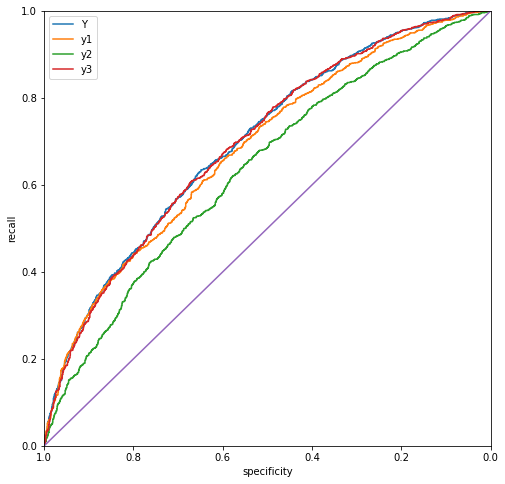

In [42]:
#'purpose_','dti','borrower_score','payment_inc_ratio'
fpr,tpr,thresholds = skl.roc_curve(Y,logit_reg.predict_proba(X)[:,0], pos_label = 'default')
roc_df = pd.DataFrame({'recall':tpr,'specificity':1-fpr})
#'purpose_','dti','borrower_score'
fpr1,tpr1,thresholds1 = skl.roc_curve(y1,logit_reg1.predict_proba(x1)[:,0], pos_label = 'default')
roc_df1 = pd.DataFrame({'recall':tpr1,'specificity':1-fpr1})
#'purpose_','dti','payment_inc_ratio'
fpr2,tpr2,thresholds2 = skl.roc_curve(y2,logit_reg2.predict_proba(x2)[:,0], pos_label = 'default')
roc_df2 = pd.DataFrame({'recall':tpr2,'specificity':1-fpr2})
#'purpose_','borrower_score','payment_inc_ratio'
fpr3,tpr3,thresholds3 = skl.roc_curve(y3,logit_reg3.predict_proba(x3)[:,0], pos_label = 'default')
roc_df3 = pd.DataFrame({'recall':tpr3,'specificity':1-fpr3})


#ROC곡선 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(1-fpr,tpr,label = 'Y')
ax.plot(1-fpr1,tpr1,label = 'y1')
ax.plot(1-fpr2,tpr2,label = 'y2')
ax.plot(1-fpr3,tpr3,label = 'y3')
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.legend()

### AUC값

In [47]:
print('purpose_ + dti + borrower_score + payment_inc_ratio :',skl.roc_auc_score([1 if yi == 'default' else 0 for yi in Y], logit_reg.predict_proba(X)[:,0]))
print('purpose_ + dti + borrower_score :',skl.roc_auc_score([1 if yi == 'default' else 0 for yi in y1], logit_reg1.predict_proba(x1)[:,0]))
print('purpose_ + dti + payment_inc_ratio :',skl.roc_auc_score([1 if yi == 'default' else 0 for yi in y2], logit_reg2.predict_proba(x2)[:,0]))
print('purpose_ + borrower_score + payment_inc_ratio :',skl.roc_auc_score([1 if yi == 'default' else 0 for yi in y3], logit_reg3.predict_proba(x3)[:,0]))

purpose_ + dti + borrower_score + payment_inc_ratio : 0.6978546712802769
purpose_ + dti + borrower_score : 0.6837648393951868
purpose_ + dti + payment_inc_ratio : 0.6348628711934935
purpose_ + borrower_score + payment_inc_ratio : 0.6956016422078573


# 5) 분류할 target variable이 0과 1인 레코드가 각각 몇 개인지 구하기 

In [49]:
data[data['outcome'] == 'default']

,outcome,purpose_,dti,borrower_score,payment_inc_ratio
1,default,credit_card,15.49,0.40,5.43165
4,default,debt_consolidation,16.46,0.45,12.10320
6,default,debt_consolidation,29.79,0.40,7.00390
10,default,other,11.42,0.40,1.82061
13,default,credit_card,14.79,0.50,2.42371
...,...,...,...,...,...
2993,default,debt_consolidation,33.74,0.30,10.88980
2994,default,debt_consolidation,15.34,0.40,9.09024
2997,default,debt_consolidation,16.13,0.20,15.42180
2998,default,debt_consolidation,18.39,0.45,8.92335


### -> default(1)인 레코드 1445개, paid off(0)인 레코드 1555개

# 5-1) oversample 후 분류모델을 학습해 그 결과를 원래 모델과 비교하기

In [52]:
data_over = pd.concat([data,data[data['outcome']=='paid off'],data[data['outcome']=='paid off'],data[data['outcome']=='paid off'],data[data['outcome']=='paid off'],data[data['outcome']=='paid off'],data[data['outcome']=='paid off'],data[data['outcome']=='paid off'],data[data['outcome']=='paid off'],data[data['outcome']=='paid off'],],axis = 0)
data_over.reset_index(drop=True,inplace=True)
data_over

,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,paid off,debt_consolidation,21.23,0.40,5.11135
1,default,credit_card,15.49,0.40,5.43165
2,paid off,debt_consolidation,27.30,0.70,9.23003
3,paid off,major_purchase,21.11,0.40,2.33482
4,default,debt_consolidation,16.46,0.45,12.10320
...,...,...,...,...,...
16990,paid off,debt_consolidation,7.25,0.50,4.67091
16991,paid off,credit_card,14.58,0.65,4.55319
16992,paid off,debt_consolidation,19.10,0.40,8.17149
16993,paid off,debt_consolidation,13.30,0.50,18.36620


In [56]:
predictors10 = ['dti','borrower_score']
outcome = 'outcome'

x10 = data_over[predictors10]
y10 = data_over[outcome]

data_lda10 = sk.LinearDiscriminantAnalysis()
data_lda10.fit(x10,y10)
pd.DataFrame(data_lda10.scalings_, index = x10.columns)

,0
dti,-0.039968
borrower_score,7.210341


In [57]:
pred10 = pd.DataFrame(data_lda10.predict_proba(x10), columns = data_lda10.classes_)
pred10

,default,paid off
0,0.144550,0.855450
1,0.127254,0.872746
2,0.046869,0.953131
3,0.144169,0.855831
4,0.106001,0.893999
...,...,...
16990,0.069101,0.930899
16991,0.042802,0.957198
16992,0.137915,0.862085
16993,0.079793,0.920207


#### 혼동 행렬 구하기

In [63]:
pred10 = data_lda10.predict(x10)
pred_y10 = data_lda10.predict(x10) == 'default'
true_y10 = y10 == 'default'
true_pos10 = true_y10&pred_y10
true_neg10 = ~true_y10&~pred_y10
false_pos10 = ~true_y10&pred_y10
false_neg10 = true_y10&~pred_y10

conf_mat10 = pd.DataFrame([[np.sum(true_pos10), np.sum(false_neg10)],[np.sum(false_pos10),np.sum(true_neg10)]], index = ['outcome = default(1)','outcome = paid off(0)'], columns = ['pred = default(1)','pred = paid off(0)'])
conf_mat10

,pred = default(1),pred = paid off(0)
outcome = default(1),0,1445
outcome = paid off(0),0,15550


### -> paid off값이 10배가 되면서 예측값이 paid off일 확률이 높아져 예측값이 default인 확률이 0이 되었다.

## 보너스) 누적 이득 차트를 그리고 리프트 값을 구하기

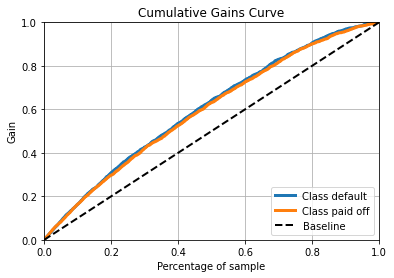

In [99]:
Y_test = data[outcome2]
Y_pred = logit_reg.predict_proba(X)
skplt.metrics.plot_cumulative_gain(Y_test, Y_pred)
plt.show()

- 두 변수의 누적이득차트가 거의 비슷하므로 리프트 값은 1에 근접한다.

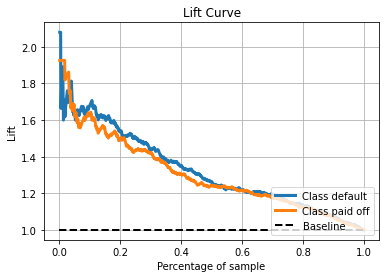

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.33)
lr = logit_reg.fit(X_train,Y_train)
Y_probas = logit_reg.predict_proba(X_test)
skplt.metrics.plot_lift_curve(Y_test, Y_probas)
plt.show()